# Wine Quality Prediction - Regression

![](https://cdn.pixabay.com/photo/2016/03/09/11/53/wine-glasses-1246240_1280.jpg)

## Frame the problem

We have a dataset that contains various characteristics of red and white variants of the Portuguese "Vinho Verde" wine. We have chemical variables, such as the amount of alcohol, citric acid, acidity, density, pH, etc; as well as a sensorial and subjective variable such as the score with which a group of experts rated the quality of the wine: between 0 (very bad) and 10 (very excellent).

They ask us to build a model that can predict the quality score given these biochemical indicators.

For this first part of the study, we are going to consider that it is a **regression problem**.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet, Ridge
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn import metrics


%matplotlib inline

## Get the Data

In [2]:
red = pd.read_csv("../input/red-wine-quality-cortez-et-al-2009/winequality-red.csv")

### Check the size and type of data

In [3]:
red.shape

(1599, 12)

In [4]:
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
pd.DataFrame({"Type": red.dtypes,
              "Unique": red.nunique(),
              "Null": red.isnull().sum(),
              "Null percent": red.isnull().sum() / len(red),
              "Mean": red.mean(),
              "Std": red.std()})

,Type,Unique,Null,Null percent,Mean,Std
fixed acidity,float64,96,0,0.0,8.319637,1.741096
volatile acidity,float64,143,0,0.0,0.527821,0.179060
citric acid,float64,80,0,0.0,0.270976,0.194801
residual sugar,float64,91,0,0.0,2.538806,1.409928
chlorides,float64,153,0,0.0,0.087467,0.047065
free sulfur dioxide,float64,60,0,0.0,15.874922,10.460157
total sulfur dioxide,float64,144,0,0.0,46.467792,32.895324
density,float64,436,0,0.0,0.996747,0.001887
pH,float64,89,0,0.0,3.311113,0.154386
sulphates,float64,96,0,0.0,0.658149,0.169507


Mmmmm, there are no nulls, what a data set!

In [7]:
red.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


## Explore the Data

How are the features distributed?

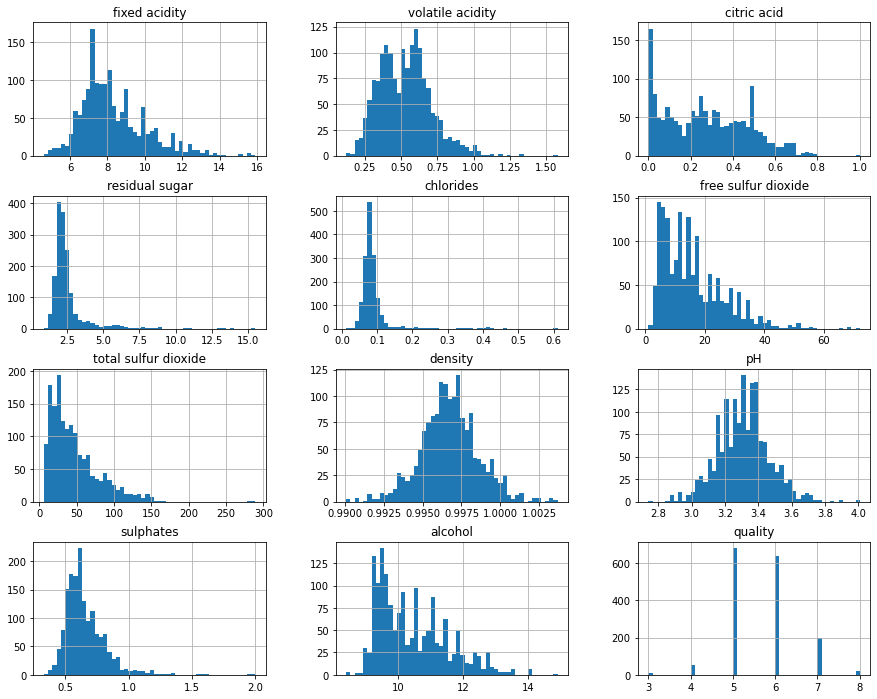

In [8]:
red.hist(bins=50, figsize=(15,12));

Let's check how our target variable, the quality score, is distributed:

In [9]:
print(f"Percentage of quality scores")
red["quality"].value_counts(normalize=True) * 100

Percentage of quality scores


5    42.589118
6    39.899937
7    12.445278
4     3.314572
8     1.125704
3     0.625391
Name: quality, dtype: float64

It is significantly unbalanced. Most instances (82%) have scores of 6 or 5.

We are going to check the correlations between the attributes of the dataset:

In [10]:
corr_matrix = red.corr()
corr_matrix

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


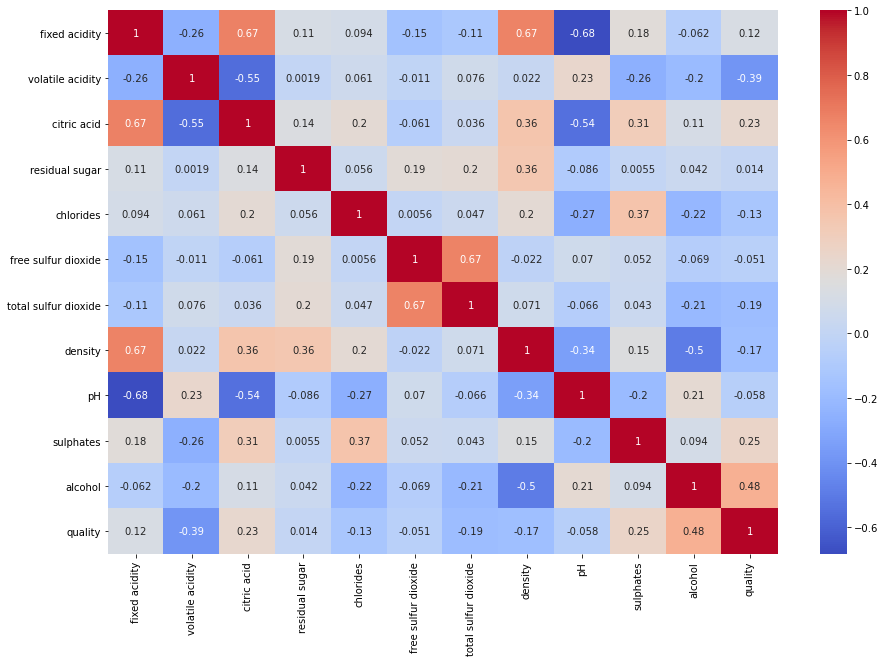

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(red.corr(), annot=True, cmap='coolwarm')
plt.show()

We show only the correlations of the target variable with the rest of the attributes:

In [12]:
corr_matrix["quality"].drop("quality").sort_values(ascending=False)

alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

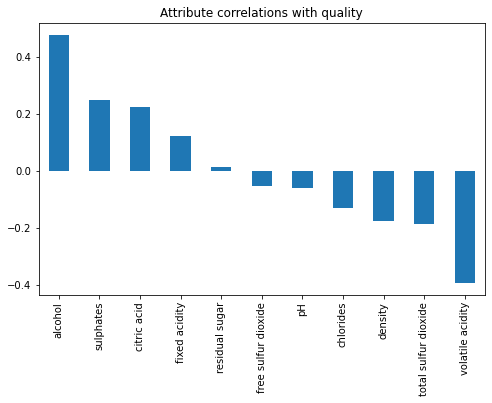

In [13]:
plt.figure(figsize=(8,5))
corr_matrix["quality"].drop("quality").sort_values(ascending=False).plot(kind='bar')
plt.title("Attribute correlations with quality")
plt.show()

## Prepare the Data

Create the predictor set and the set with the target variable:

In [14]:
predict_columns = red.columns[:-1]
predict_columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [15]:
X = red[predict_columns]
y = red["quality"]

Create the training and test datasets:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [17]:
X_train.shape, y_train.shape

((1279, 11), (1279,))

In [18]:
X_test.shape, y_test.shape

((320, 11), (320,))

## Shortlist Promising Models

OK, we're going train several quick-and-dirty models from different categories using standard parameters. We selected some of the regression models: Linear Regression, Lasso, ElasticNet, Ridge, Extre Trees, and RandomForest.

In [19]:
def evaluate_model(estimator, X_train, y_train, cv=10, verbose=True):
    """Print and return cross validation of model
    """
    scoring = ["neg_mean_absolute_error", "neg_mean_squared_error", "r2"]
    scores = cross_validate(estimator, X_train, y_train, return_train_score=True, cv=cv, scoring=scoring)
    
    val_mae_mean, val_mae_std = -scores['test_neg_mean_absolute_error'].mean(), \
                                -scores['test_neg_mean_absolute_error'].std()
    
    train_mae_mean, train_mae_std = -scores['train_neg_mean_absolute_error'].mean(), \
                                    -scores['train_neg_mean_absolute_error'].std()
    
    val_mse_mean, val_mse_std = -scores['test_neg_mean_squared_error'].mean(), \
                                -scores['test_neg_mean_squared_error'].std()
    
    train_mse_mean, train_mse_std = -scores['train_neg_mean_squared_error'].mean(), \
                                    -scores['train_neg_mean_squared_error'].std()
    
    val_rmse_mean, val_rmse_std = np.sqrt(-scores['test_neg_mean_squared_error']).mean(), \
                                  np.sqrt(-scores['test_neg_mean_squared_error']).std()
    
    train_rmse_mean, train_rmse_std = np.sqrt(-scores['train_neg_mean_squared_error']).mean(), \
                                      np.sqrt(-scores['train_neg_mean_squared_error']).std()
    
    val_r2_mean, val_r2_std = scores['test_r2'].mean(), scores['test_r2'].std()
    
    train_r2_mean, train_r2_std = scores['train_r2'].mean(), scores['train_r2'].std()

    
    result = {
        "Val MAE": val_mae_mean,
        "Val MAE std": val_mae_std,
        "Train MAE": train_mae_mean,
        "Train MAE std": train_mae_std,
        "Val MSE": val_mse_mean,
        "Val MSE std": val_mse_std,
        "Train MSE": train_mse_mean,
        "Train MSE std": train_mse_std,
        "Val RMSE": val_rmse_mean,
        "Val RMSE std": val_rmse_std,
        "Train RMSE": train_rmse_mean,
        "Train RMSE std": train_rmse_std,
        "Val R2": val_r2_mean,
        "Val R2 std": val_r2_std,
        "Train R2": train_rmse_mean,
        "Train R2 std": train_r2_std,
    }
    
    if verbose:
        print(f"val_MAE_mean: {val_mae_mean} - (std: {val_mae_std})")
        print(f"train_MAE_mean: {train_mae_mean} - (std: {train_mae_std})")
        print(f"val_MSE_mean: {val_mse_mean} - (std: {val_mse_std})")
        print(f"train_MSE_mean: {train_mse_mean} - (std: {train_mse_std})")
        print(f"val_RMSE_mean: {val_rmse_mean} - (std: {val_rmse_std})")
        print(f"train_RMSE_mean: {train_rmse_mean} - (std: {train_rmse_std})")
        print(f"val_R2_mean: {val_r2_mean} - (std: {val_r2_std})")
        print(f"train_R2_mean: {train_r2_mean} - (std: {train_r2_std})")

    return result

In [20]:
models = [LinearRegression(), Lasso(alpha=0.1), ElasticNet(),
          Ridge(), ExtraTreesRegressor(), RandomForestRegressor()]

model_names = ["Lineal Regression", "Lasso", "ElasticNet",
               "Ridge", "Extra Tree", "Random Forest"]

In [21]:
mae = []
mse = []
rmse = []
r2 = []

for model in range(len(models)):
    print(f"Paso {model+1} de {len(models)}")
    print(f"...running {model_names[model]}")
    
    rg_scores = evaluate_model(models[model], X_train, y_train)
    
    mae.append(rg_scores["Val MAE"])
    mse.append(rg_scores["Val MSE"])
    rmse.append(rg_scores["Val RMSE"])
    r2.append(rg_scores["Val R2"])

Paso 1 de 6
...running Lineal Regression
val_MAE_mean: 0.5054157041773432 - (std: -0.04626497254937263)
train_MAE_mean: 0.49951141240221775 - (std: -0.0053968346778861245)
val_MSE_mean: 0.43633668466538794 - (std: -0.0713599197838866)
train_MSE_mean: 0.42355991601136395 - (std: -0.007783364048942032)
val_RMSE_mean: 0.6578988186927085 - (std: 0.059210041615646414)
train_RMSE_mean: 0.6507877560250832 - (std: 0.005934022177307527)
val_R2_mean: 0.3230213163533237 - (std: 0.09729583232858707)
train_R2_mean: 0.3488833601783283 - (std: 0.00898820778651704)
Paso 2 de 6
...running Lasso
val_MAE_mean: 0.5542159398138832 - (std: -0.04404488153789954)
train_MAE_mean: 0.5519267693601051 - (std: -0.005222359881914161)
val_MSE_mean: 0.5011613158962728 - (std: -0.07980261731926686)
train_MSE_mean: 0.49648903729654786 - (std: -0.00886434349442918)
val_RMSE_mean: 0.7054560563903938 - (std: 0.059102186071128736)
train_RMSE_mean: 0.7045920060170998 - (std: 0.006256385006291064)
val_R2_mean: 0.225504570169

Let's see the performance of each of them:

In [22]:
df_result = pd.DataFrame({"Model": model_names,
                          "MAE": mae,
                          "MSE": mse,
                          "RMSE": rmse,
                          "R2": r2})
df_result

,Model,MAE,MSE,RMSE,R2
0,Lineal Regression,0.505416,0.436337,0.657899,0.323021
1,Lasso,0.554216,0.501161,0.705456,0.225505
2,ElasticNet,0.648483,0.626070,0.789197,0.032300
3,Ridge,0.505202,0.435361,0.657134,0.324764
4,Extra Tree,0.377767,0.338853,0.578611,0.476415
5,Random Forest,0.421004,0.354207,0.592205,0.450652


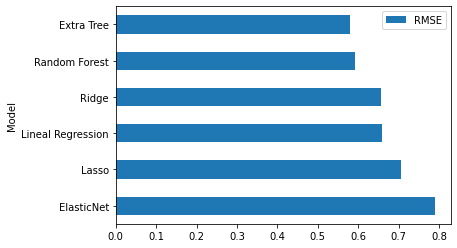

In [23]:
df_result.sort_values(by="RMSE", ascending=False).plot.barh("Model", "RMSE");

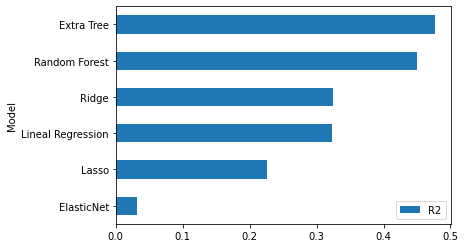

In [24]:
df_result.sort_values(by="R2").plot.barh("Model", "R2");

The model that gives the best results is **extra trees**. RMSE = 0.577591 and R2 = 0.477845. Let's fine tune it.

## Fine-Tune

In [25]:
param_grid = [
    {'n_estimators': range(10, 300, 10), 'max_features': [2, 3, 4, 5, 8, "auto"], 'bootstrap': [True, False]}
]


xtree_reg = ExtraTreesRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(xtree_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42),
             param_grid=[{'bootstrap': [True, False],
                          'max_features': [2, 3, 4, 5, 8, 'auto'],
                          'n_estimators': range(10, 300, 10)}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 5, 'n_estimators': 160}

It's the moment of truth! Let's see the performance on the test set:

In [27]:
final_model = grid_search.best_estimator_
y_pred = final_model.predict(X_test)

In [28]:
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"R2: {final_model.score(X_test, y_test)}")

MAE: 0.38298828124999995
MSE: 0.28038391113281247
RMSE: 0.5295128998738486
R2: 0.5709542506612473


Well, a little better!

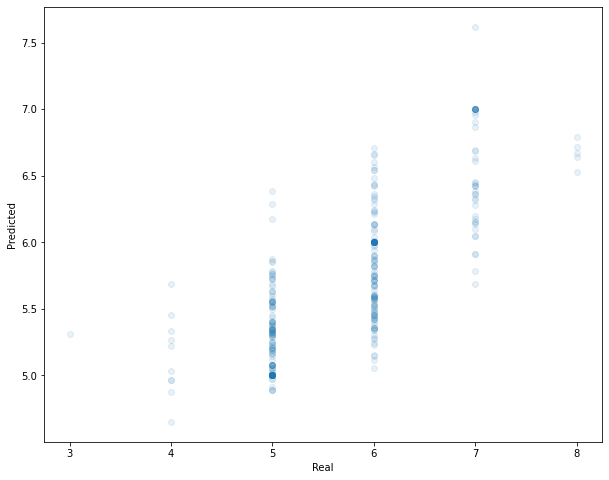

In [29]:
plt.figure(figsize=(10,8))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.show()

Let's see which features are most relevant:

In [30]:
feature_importances = final_model.feature_importances_
feature_importances

array([0.06242878, 0.12054219, 0.07478461, 0.06697772, 0.06670251,
       0.05944129, 0.07925392, 0.07148382, 0.06178626, 0.12593217,
       0.21066673])

In [31]:
sorted(zip(feature_importances, X_test.columns), reverse=True)

[(0.21066672921314536, 'alcohol'),
 (0.12593217102849721, 'sulphates'),
 (0.12054219432817319, 'volatile acidity'),
 (0.07925392046422038, 'total sulfur dioxide'),
 (0.07478461494308854, 'citric acid'),
 (0.07148382305429933, 'density'),
 (0.06697771630809288, 'residual sugar'),
 (0.0667025052273382, 'chlorides'),
 (0.062428775664599825, 'fixed acidity'),
 (0.06178625839728167, 'pH'),
 (0.05944129137126336, 'free sulfur dioxide')]

Text(0.5, 1.0, 'Feature Importances')

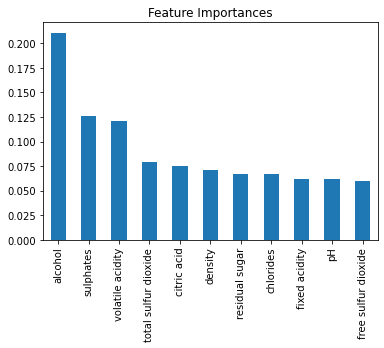

In [32]:
feature_imp = pd.Series(feature_importances, index=X_train.columns).sort_values(ascending=False)
feature_imp.plot(kind='bar')
plt.title('Feature Importances')

Let's see how the errors are distributed:

In [33]:
df_resul = pd.DataFrame({"Pred": y_pred,
              "Real": y_test,
              "error": y_pred - y_test,
              "error_abs": abs(y_pred - y_test)})

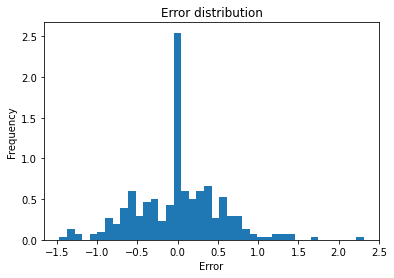

In [34]:
df_resul["error"].plot.hist(bins=40, density=True)
plt.title("Error distribution")
plt.xlabel("Error");

More generally, What's the MAE that occurs in each quality score?

In [35]:
df_resul.groupby("Real")["error_abs"].mean()

Real
3    2.312500
4    1.144375
5    0.296827
6    0.324100
7    0.494792
8    1.330000
Name: error_abs, dtype: float64

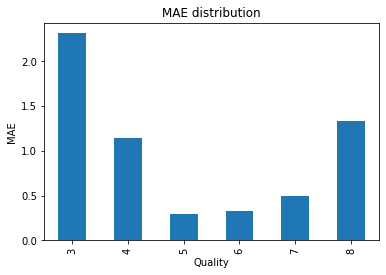

In [36]:
df_resul.groupby("Real")["error_abs"].mean().plot.bar()
plt.title("MAE distribution")
plt.ylabel("MAE")
plt.xlabel("Quality");

## Conclusions

After testing various models, the one that provided the best results is ExtraTrees. After fine tuning it, we get a significant improvement.

The basic line regression model offers an R2: 0.323021 and RMSE: 0.657899. The Extra Tree model offers an R2: 0.529512 and RMSE: 0.570954. However, the R2 score is still very low. According to the value obtained from R2, our model can barely explain 52% of the variance. That is, the percentage of relationship between the variables that can be explained by our model is 52.95%.

According to the MAE distribution graph, we can see that our model is not good for extreme scores. In fact, it is not capable of predicting any score of 3 or 8. As we saw in the distribution of the target variable, it is very unbalanced, there are hardly any observations for the extreme values, so the model does not have enough data training for all quality scores.

As a final consideration, we should try to approach modeling as a classification problem, to evaluate if it offers better results than a regression problem. We will see it in part 2 of this analysis.